In [2]:
import numpy as np
import pandas as pd
import os
import sys
import glob
from jupyterthemes import jtplot

In [17]:
jtplot.style('default', grid=False)
from confocal.confocal_sw import *

# Study bleaching of small droplet 

In [4]:
f1, f2 = load_jpg_path('fluorescein_incidental_droplets_70ms_12pulses_29052019/bleach')

/Users/pabloherrero/Documents/confocal/fluorescein_incidental_droplets_70ms_12pulses_29052019/bleach/Series*.jpg
Found  343 0  files


In [8]:
len(f1[:-1:20])

18

1 18


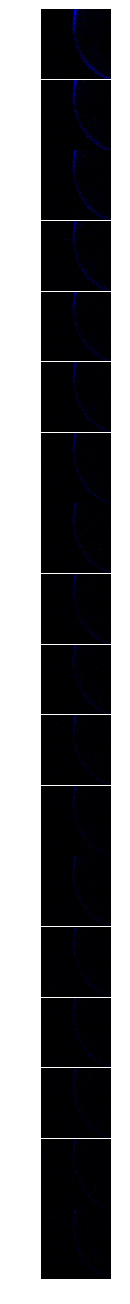

In [9]:
plot_whole_grid(f1[:-1:20], cols=1, rows=18, size=1)

In [15]:
av = [cv2.mean(cv2.imread(x))[0] for x in f1]

## Separate image in droplet and background

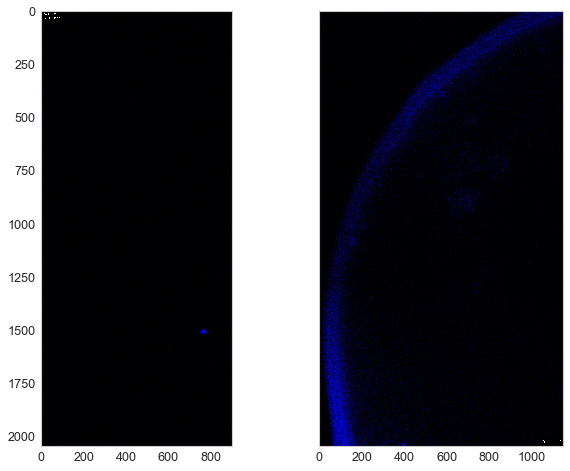

In [66]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,8))
im = f1[0]
image = plt.imread(im)
drop = image[:, 900:]
bg = image[:, :900]

ax[0].imshow(bg)
ax[1].imshow(drop)


#####  Here a next step might be to cut along an arc of line instead of a straight line

In [27]:
len(f1[:300:step])

8

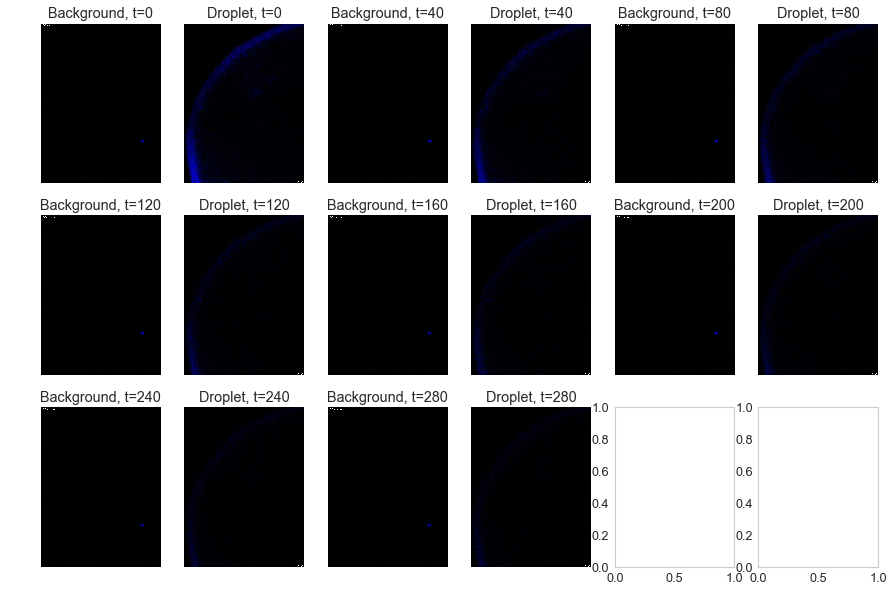

In [27]:
step = 40
xcut = 900
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(15,10))
for j, im in enumerate(f1[:300:step]):
    i = int(j/3)
    k = j % 3
    image = plt.imread(im)
    if xcut != None:
        drop = image[:, xcut:]
        bg = image[:, :xcut]
    elif ycut != None:
        drop = image[ycut:, :]
        bg = image[:ycut, :]

    ax[i,2*k].imshow(bg)
    ax[i,2*k + 1].imshow(drop)
    ax[i,2*k].set_title('Background, t=%i'%(j*step))
    ax[i,2*k + 1].set_title('Droplet, t=%i'%(j*step))

    ax[i,2*k].axis('off'), ax[i,2*k].axis('tight')
    ax[i,2*k+1].axis('off'), ax[i,2*k+1].axis('tight')
# plt.savefig('sample_images.jpg', dpi=100)

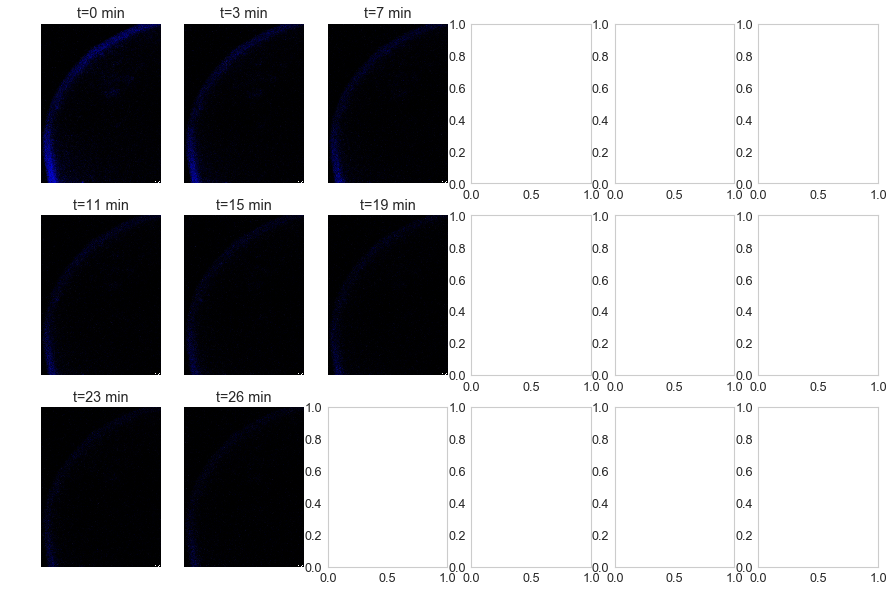

In [28]:
step = 40
xcut = 900
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(15,10))
for j, im in enumerate(f1[:300:step]):
    i = int(j/3)
    k = j % 3
    image = plt.imread(im)
    if xcut != None:
        drop = image[:, xcut:]
    elif ycut != None:
        drop = image[ycut:, :]

    ax[i,k].imshow(drop)
    ax[i,k].set_title('t=%i min'%(j*tav*step//60))

    ax[i,k].axis('off'), ax[i,k].axis('tight')
# plt.savefig('sample_images.jpg', dpi=100)

## Analyse intensity decay

In [37]:
avDrop = [cv2.mean(cv2.imread(x)[:, 900:])[0] for x in f1]
avBg = [cv2.mean(cv2.imread(x)[:, :900])[0] for x in f1]

lenBg = cv2.imread(f1[0])[:, 900:].size/3
lenDrop = cv2.imread(f1[0])[:, :900].size/3

davDrop = [cv2.meanStdDev(cv2.imread(x)[:, 900:])[1][0][0]/lenDrop for x in f1]
davBg = [cv2.meanStdDev(cv2.imread(x)[:, :900])[1][0][0]/lenBg for x in f1]

In [7]:
from dataclasses import dataclass
@dataclass
class Bleach:
    """Class to manage and compute bleaching in a time series"""
    path : str
    seriesName : str
        
    def get_properties_xml(self) -> str:
        return os.path.join(self.path, self.seriesName+'_Properties.xml')
    
    def get_jpg_names(self) -> list:
        regexp = os.path.join(self.path, self.seriesName + '_*.jpg')
#         print(regexp)
        f = glob.glob(os.path.expandvars(regexp))
        f.sort()
        return f
        
    def get_relative_time(self) -> list:
        """Get relative timestamp of a Leica Series from its Properties.xml file
        Parameters    
        ------------
        properties_xml : path
            path and name of SeriesX_Properties.xml file
        """
        properties_xml = self.get_properties_xml()
        
        with open(properties_xml, 'r') as filebytes:
            lines = filebytes.read()
            tstamp = []

        # Find float pattern attributed to RelativeTime and append to array
            for match in re.finditer('RelativeTime="(\d+\.\d+)"', lines):
        #         print(match.group(1))
                tstamp.append(float(match.group(1)))

        # Include also integers (no decimal point) and then sort by order
            for match in re.finditer('RelativeTime="(\d+)"', lines):
                tstamp.append(float(match.group(1)))

            tstamp = np.array(tstamp)        
            tstamp.sort()
            return tstamp
    def average_drop_bg(self, xcut):
        jpg_files = self.get_jpg_names()
        
        avDrop = [cv2.mean(cv2.imread(x)[:, xcut:])[0] for x in jpg_files]
        avBg = [cv2.mean(cv2.imread(x)[:, :xcut])[0] for x in jpg_files]

        lenBg = cv2.imread(jpg_files[0])[:, xcut:].size/3
        lenDrop = cv2.imread(jpg_files[0])[:, :xcut].size/3

        davDrop = [cv2.meanStdDev(cv2.imread(x)[:, xcut:])[1][0][0]/lenDrop for x in jpg_files]
        davBg = [cv2.meanStdDev(cv2.imread(x)[:, :xcut])[1][0][0]/lenBg for x in jpg_files]
        
        return [avDrop, davDrop, avBg, davBg]

In [8]:
path = '/Users/pabloherrero/Documents/confocal/fluorescein_incidental_droplets_70ms_12pulses_29052019/bleach'
seriesName = 'Series004'
im_bleach = Bleach(path, seriesName)
[avDrop, davDrop, avBg, davBg] = im_bleach.average_drop_bg()

In [13]:
tstamp = im_bleach.get_relative_time()

In [23]:
tstep = tstamp[1:] - tstamp[:-1]
tav, tsd = np.average(tstep), np.std(tstep)
tav, tsd

(5.769690058479532, 0.04349904704874131)

In [15]:
from scipy.optimize import curve_fit
def exp(t, a, b, c):
    return a + b * np.exp(-c * t)

fitBg, covBg = curve_fit(exp, tstamp, avBg, sigma = davBg, absolute_sigma=True)
fitDrop, covDrop = curve_fit(exp, tstamp, avDrop, sigma = davDrop, absolute_sigma=True)

ltBg = np.log(2)/fitBg[2]
dltBg = ltBg/fitBg[2]*covBg[2,2]

ltDrop = np.log(2)/fitDrop[2]
dltDrop = ltDrop/fitDrop[2]*covDrop[2,2]

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/scipy/optimize/minpack.py:466: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


In [21]:
fitBg, covBg

(array([1.1741532 , 0.13993785, 0.00205013]),
 array([[ 8.12593815e-14, -2.13763569e-14,  4.09878725e-15],
        [-2.13763569e-14,  2.23064702e-13,  2.11806515e-15],
        [ 4.09878725e-15,  2.11806515e-15,  3.01804813e-16]]))

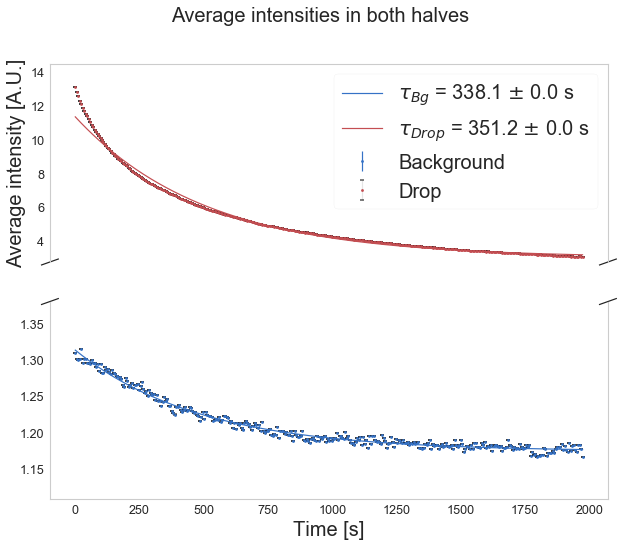

In [19]:

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))

markers, caps, bars = ax2.errorbar(tstamp, avBg, yerr=davBg, fmt='.b', 
                                   ecolor='black',capsize=2, capthick=2)
# loop through bars and caps and set the alpha value
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

ax.errorbar(tstamp[0], avBg[0], yerr=davBg[0], fmt='.b', label='Background')
ax2.plot(tstamp, exp(tstamp, *fitBg), '-b')
ax.plot(tstamp, exp(tstamp, *fitBg), '-b', label='$\\tau_{Bg}$ = %.1f $\pm$ %.1f s' %(ltBg, dltBg))

markers, caps, bars = ax.errorbar(tstamp, avDrop, yerr=davDrop, fmt='.r', label='Drop',
                                   ecolor='black',capsize=2, capthick=2)
# loop through bars and caps and set the alpha value
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

ax.plot(tstamp, exp(tstamp, *fitDrop), '-r', label='$\\tau_{Drop}$ = %.1f $\pm$ %.1f s' %(ltDrop, dltDrop))

ax2.set_ylim(0.95*min(avBg), 1.05*max(avBg))
ax.set_ylim(0.9*min(avDrop), 1.1*max(avDrop))

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

### Cosmetics for diagonal cut between axes
d = 0.015
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
########
fig.suptitle('Average intensities in both halves', fontsize = 20)
ax2.set_xlabel('Time [s]', fontsize = 20)
ax.set_ylabel('Average intensity [A.U.]', fontsize = 20)
ax.legend(loc='best', fontsize = 20)


# plt.savefig('intesities_decay.jpg', dpi=100)
plt.show()


In [ ]:
def average_intensity_decay(f : list, )

    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))

    markers, caps, bars = ax2.errorbar(tstamp, avBg, yerr=davBg, fmt='.b', 
                                       ecolor='black',capsize=2, capthick=2)
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.1) for bar in bars]
    [cap.set_alpha(0.5) for cap in caps]

    ax.errorbar(tstamp[0], avBg[0], yerr=davBg[0], fmt='.b', label='Background')
    ax2.plot(tstamp, exp(tstamp, *fitBg), '-b')
    ax.plot(tstamp, exp(tstamp, *fitBg), '-b', label='$\\tau_{Bg}$ = %.1f $\pm$ %.1f s' %(ltBg, dltBg))

    markers, caps, bars = ax.errorbar(tstamp, avDrop, yerr=davDrop, fmt='.r', label='Drop',
                                       ecolor='black',capsize=2, capthick=2)
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.1) for bar in bars]
    [cap.set_alpha(0.5) for cap in caps]

    ax.plot(tstamp, exp(tstamp, *fitDrop), '-r', label='$\\tau_{Drop}$ = %.1f $\pm$ %.1f s' %(ltDrop, dltDrop))

    ax2.set_ylim(65, 75)
    ax.set_ylim(180, 205)

    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    ### Cosmetics for diagonal cut between axes
    d = 0.015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    ########
    fig.suptitle('Average intensities in both halves', fontsize = 20)
    ax2.set_xlabel('Time [s]', fontsize = 20)
    ax.set_ylabel('Average intensity [A.U.]', fontsize = 20)
    ax.legend(loc='best', fontsize = 20)


    # plt.savefig('intesities_decay.jpg', dpi=100)
    plt.show()
